In [156]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
from ultralytics import YOLO
import  math
import csv
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import os
import chess
import chess.svg


<br>

#### Display Image

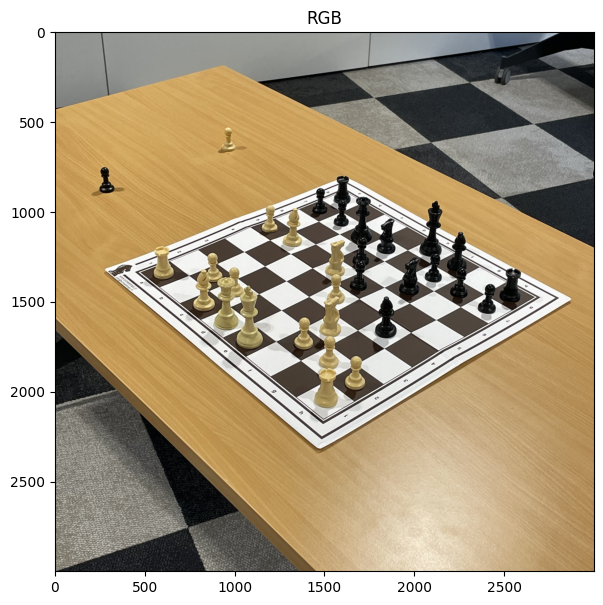

In [157]:
# Path of Image that you want to convert
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\0\G000_IMG014.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\photo_5879853732403989244_y.jpg"
# image_path = r"C:\Users\Alessandro\Downloads\photo_5879853732403989239_y.jpg"
image_path = r"C:\Users\Alessandro\Downloads\Dynamic-Chess-Board-Piece-Extraction-master\test-images\test-8.jpeg"
image_path = r"D:\Projects\Uni\Chessy3D\data\ra2k\images\33\G033_IMG017.jpg"

# read image and convert it to different color spaces 
image = cv2.imread(image_path)
image = cv2.resize(image, (3000, 3000))

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

original_size = 1000
scale_factor = image.shape[0] / original_size

plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

In [158]:
import itertools

t1 = [25, 50, 100, 200, 300, 400]
t2 = [50, 100, 200, 300, 400, 500]
# t1 = [25, 50, 100, 200, 300]
# t2 = [50, 60, 75, 100, 200, 300]

params = [x for x in itertools.product(t1, t2)]
cannies_images = []

blurred_image = cv2.GaussianBlur(gray_image,(5,5),0)
can_kernel = np.ones((7, 7), np.uint8)

rows = len(t1)
cols = len(t2)
plt.figure(figsize=(50,50))
for idx, (t1, t2) in enumerate(params):
    can = cv2.Canny(blurred_image, t1, t2) # é stato modificato questo input per creare le varie immagini
    can = cv2.dilate(can, can_kernel, iterations=1)
    cannies_images.append(can)

    # ax = plt.subplot(rows, cols, idx + 1)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # plt.title(f'{t1} {t2}')
    # plt.imshow(can, cmap='gray')


<Figure size 5000x5000 with 0 Axes>

In [159]:
hough_images = []

kernel = np.ones((3, 3), np.uint8)

plt.figure(figsize=(50,50))
for idx, (t1,t2) in enumerate(params):
    if idx >= len(cannies_images):
        break

    can = cannies_images[idx]

    # Hough Lines
    lines = cv2.HoughLinesP(can, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)
    # lines = link_and_merge_segments_array(lines[:, 0], image.shape[0]*image.shape[1])

    # Create an image that contains only black pixels
    black_image = np.zeros_like(can)

    # Draw only lines that are output of HoughLinesP function to the "black_image"
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # draw only lines to the "black_image"
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 3)

    # Dilation
    black_image = cv2.dilate(black_image, kernel, iterations=1)
    hough_images.append(black_image)

    # ax = plt.subplot(rows, cols, idx + 1)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    # plt.title(f'{t1} {t2}')
    # plt.imshow(black_image, cmap='gray')

<Figure size 5000x5000 with 0 Axes>

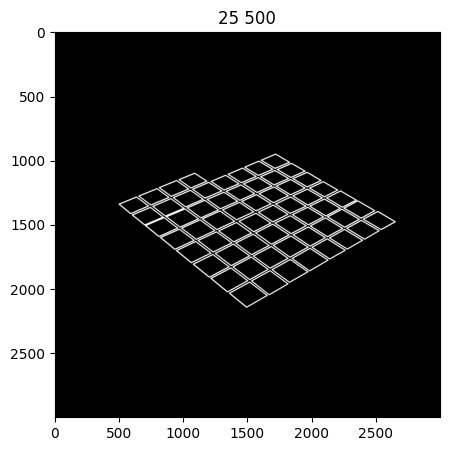

In [160]:
best_valid_square_image = None
best_valid_square_image_square_count = 0
best_t1, best_t2 = 0,0
best_square_approx = []

for idx, (t1,t2) in enumerate(params):
    black_image = hough_images[idx]
    current_valid_square_count = 0

    # Look for valid squares and check if squares are inside of board
    board_contours = []
    square_approx = []
    valid_squares_image = np.zeros_like(black_image)

    # find contours
    board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    # loop through contours and filter them by deciding if they are potential squares

    for contour in board_contours:
        if 4000*scale_factor < cv2.contourArea(contour) < 20000*scale_factor:
            # Approximate the contour to a simpler shape
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
                
            if len(approx) == 4:
                # 4 points of polygon
                pts = [pt[0].tolist() for pt in approx]
                # pts = approx[0]

                # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

                #  Y values
                if index_sorted[0][1]< index_sorted[1][1]:
                    cur=index_sorted[0]
                    index_sorted[0] =  index_sorted[1]
                    index_sorted[1] = cur

                if index_sorted[2][1]> index_sorted[3][1]:
                    cur=index_sorted[2]
                    index_sorted[2] =  index_sorted[3]
                    index_sorted[3] = cur

                # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                pt1=index_sorted[0]
                pt2=index_sorted[1]
                pt3=index_sorted[2]
                pt4=index_sorted[3]

                # find rectangle that fits 4 point 
                x, y, w, h = cv2.boundingRect(contour)
                # find center of rectangle 
                center_x=(x+(x+w))/2
                center_y=(y+(y+h))/2

                # calculate length of 4 side of rectangle
                l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
                l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
                l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
                l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)

                # Create a list of lengths
                lengths = [l1, l2, l3, l4]
                
                # Get the maximum and minimum lengths
                max_length = max(lengths)
                min_length = min(lengths)

                # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
                if (max_length - min_length) <= 50 * scale_factor: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                    valid_square=True
                else:
                    valid_square=False

                if valid_square:
                    current_valid_square_count += 1 

                    square_approx.append(approx)

                    # Draw only valid squares to "valid_squares_image"
                    cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                    cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)

    if current_valid_square_count >= best_valid_square_image_square_count:
        best_valid_square_image = valid_squares_image
        best_valid_square_image_square_count = current_valid_square_count
        best_t1, best_t2 = t1, t2
        best_square_approx = square_approx

if best_valid_square_image is None:
    raise ValueError("No best square image found")

plt.figure(figsize=(5,5))
plt.title(f'{best_t1} {best_t2}')
plt.imshow(best_valid_square_image, cmap='gray')
plt.show()

In [161]:
import cv2
import numpy as np

def extract_features(approx):
    # Centroid
    M = cv2.moments(approx)
    if M["m00"] == 0:
        return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Size (area or bounding box)
    area = cv2.contourArea(approx)
    rect = cv2.minAreaRect(approx)
    width, height = rect[1]
    angle = rect[2]  # Angle of rotation

    # Normalize angle if necessary
    if width < height:
        angle = angle + 90

    return {
        "centroid": (cx, cy),
        "area": area,
        "angle": angle,
        "size": max(width, height) * min(width, height)  # approximate area
    }


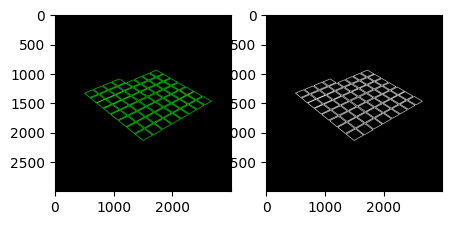

In [162]:
import numpy as np
from scipy.stats import zscore

# features is a list of dicts from extract_features()
features = [extract_features(x) for x in best_square_approx]
centroids = np.array([f["centroid"] for f in features])
areas = np.array([f["area"] for f in features])
angles = np.array([f["angle"] for f in features])
sizes = np.array([f["size"] for f in features])

# Use z-score for outlier detection
area_z = np.abs(zscore(areas))
angle_z = np.abs(zscore(angles))
size_z = np.abs(zscore(sizes))

# Distance of centroids from cluster center
center = np.mean(centroids, axis=0)
dists = np.linalg.norm(centroids - center, axis=1)
dist_z = np.abs(zscore(dists))

# Define threshold (commonly 2 or 3)
threshold = 3

# valid_indices = np.where((area_z < threshold) &
#                          (angle_z < threshold) &
#                          (size_z < threshold) &
#                          (dist_z < threshold))[0]

valid_indices = np.where((area_z < threshold) &
                         (size_z < threshold) &
                         (dist_z < threshold))[0]


valid_polygons = [best_square_approx[i] for i in valid_indices]


# SHOW RESULT

valid_polygons_image = cv2.cvtColor(best_valid_square_image,cv2.COLOR_GRAY2BGR)
only_valid_polygons_image = np.zeros_like(best_valid_square_image)
for approx in valid_polygons:
        pts = [pt[0].tolist() for pt in approx]
        # pts = approx[0]

        # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
        index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

        #  Y values
        if index_sorted[0][1]< index_sorted[1][1]:
            cur=index_sorted[0]
            index_sorted[0] =  index_sorted[1]
            index_sorted[1] = cur

        if index_sorted[2][1]> index_sorted[3][1]:
            cur=index_sorted[2]
            index_sorted[2] =  index_sorted[3]
            index_sorted[3] = cur

        # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
        pt1=index_sorted[0]
        pt2=index_sorted[1]
        pt3=index_sorted[2]
        pt4=index_sorted[3]

        # Draw only valid squares to "valid_squares_image"
        cv2.line(valid_polygons_image, pt1, pt2, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt2, pt3, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt3, pt4, (0, 255, 0), 7)
        cv2.line(valid_polygons_image, pt1, pt4, (0, 255, 0), 7)

        cv2.line(only_valid_polygons_image, pt1, pt2, 255, 7)
        cv2.line(only_valid_polygons_image, pt2, pt3, 255, 7)
        cv2.line(only_valid_polygons_image, pt3, pt4, 255, 7)
        cv2.line(only_valid_polygons_image, pt1, pt4, 255, 7)

plt.figure(figsize=(5,5))

plt.subplot(1,2,1)
plt.imshow(valid_polygons_image)

plt.subplot(1,2,2)
plt.imshow(only_valid_polygons_image, cmap='gray')

plt.show()

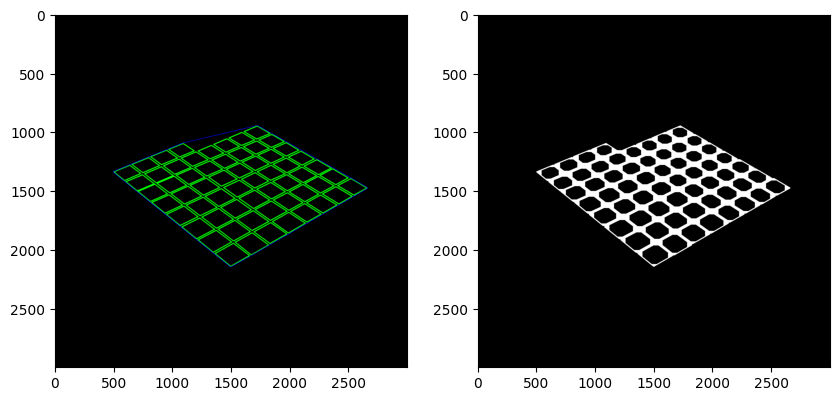

In [163]:
valid_polygons_image_gray = only_valid_polygons_image.copy()
valid_polygons_image_copy = valid_polygons_image.copy()

valid_polygons_image_gray = cv2.morphologyEx(valid_polygons_image_gray, cv2.MORPH_CLOSE, np.ones((3,3)), iterations=20)
cnts, _ = cv2.findContours(valid_polygons_image_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(cnts, key=cv2.contourArea)
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.intp(box)

convex_hull = cv2.convexHull(cnt)

# cv2.drawContours(valid_polygons_image_copy, cnts,-1, (255,0,255), 3)
# cv2.drawContours(valid_polygons_image_copy,[box],0,(255,255,0),3)
cv2.drawContours(valid_polygons_image_copy, [convex_hull], 0, (0, 0, 255), 3)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(valid_polygons_image_copy)

plt.subplot(1,2,2)
plt.imshow(valid_polygons_image_gray, cmap='gray')
plt.show()

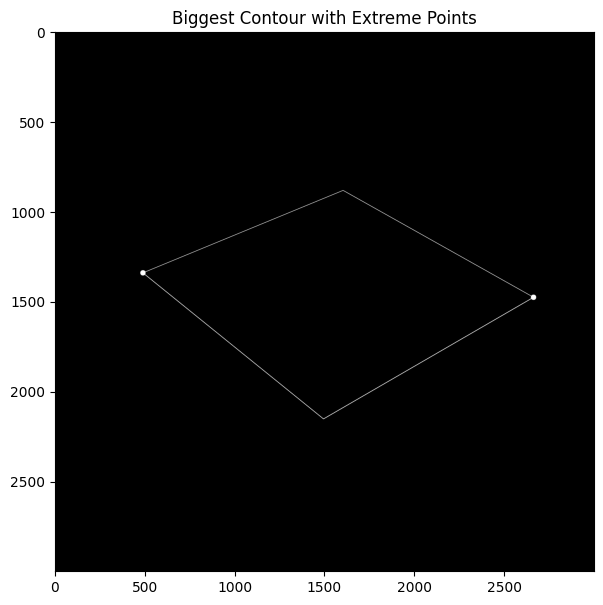

Top-left: (np.int32(489), np.int32(1340))
Top-right: (np.int32(2663), np.int32(1476))
Bottom-left: (np.int32(489), np.int32(1340))
Bottom-right: (np.int32(2663), np.int32(1476))


In [164]:
approx = cv2.approxPolyN(convex_hull, 4)

# Initialize variables to store extreme points
top_left = None
top_right = None
bottom_left = None
bottom_right = None

# Loop through the contour to find extreme points
for point in approx[0, :]:
    x, y = point

    if top_left is None or (x + y < top_left[0] + top_left[1]):
        top_left = (x, y)

    if top_right is None or (x - y > top_right[0] - top_right[1]):
        top_right = (x, y)

    if bottom_left is None or (x - y < bottom_left[0] - bottom_left[1]):
        bottom_left = (x, y)

    if bottom_right is None or (x + y > bottom_right[0] + bottom_right[1]):
        bottom_right = (x, y)

# Draw the contour and the extreme points
extreme_points_image = np.zeros_like(valid_polygons_image_gray, dtype=np.uint8)
cv2.drawContours(extreme_points_image, [approx], -1, (255, 255, 255), thickness=2)

# Mark the extreme points
# Mark the extreme points
cv2.circle(extreme_points_image, top_left, 15, (255, 255, 255), -1)  # red for top-left
cv2.circle(extreme_points_image, top_right, 15, (255, 255, 255), -1)  # green for top-right
cv2.circle(extreme_points_image, bottom_left, 15, (255, 255,255), -1)  # blue for bottom-left
cv2.circle(extreme_points_image, bottom_right, 15, (255, 255, 255), -1)  # yellow for bottom-right


# Display the result
plt.figure(figsize=(9, 7))
plt.title("Biggest Contour with Extreme Points")
plt.imshow(extreme_points_image, cmap="gray")
plt.show()

# Print out the extreme points
print("Top-left:", top_left)
print("Top-right:", top_right)
print("Bottom-left:", bottom_left)
print("Bottom-right:", bottom_right)


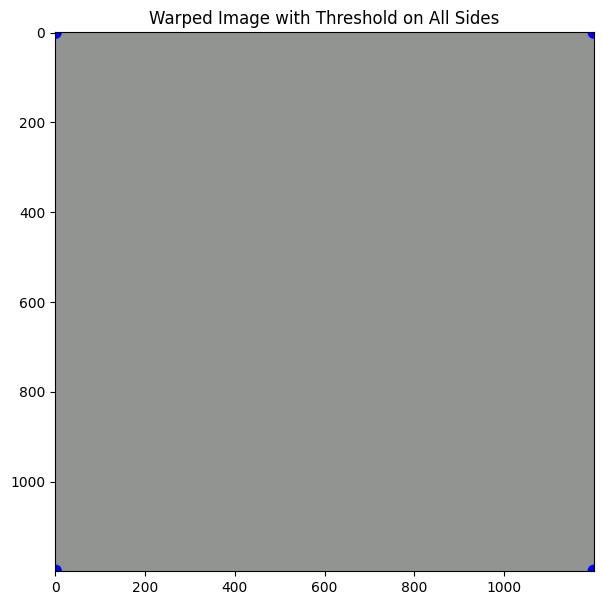

In [165]:
 
# read image and convert it to different color spaces 
# image = cv2.imread(image_path)
# rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Define the four source points (replace with actual coordinates)
extreme_points_list = np.float32([top_left, top_right, bottom_left, bottom_right])

threshold = 0  # Extra space on all sides

width, height = 1200 , 1200 

# Define the destination points (shifted by 'threshold' on all sides)
dst_pts = np.float32([
    [threshold, threshold], 
    [width + threshold, threshold], 
    [threshold, height + threshold], 
    [width + threshold, height + threshold]
])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(extreme_points_list, dst_pts)

# Apply the transformation with extra width and height
warped_image = cv2.warpPerspective(rgb_image, M, (width + 2 * threshold, height + 2 * threshold))

cv2.circle(warped_image, (threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (width + threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (threshold, height + threshold), 15, (0, 0,255), -1)  
cv2.circle(warped_image, (width + threshold, height + threshold), 15, (0, 0, 255), -1)   

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Warped Image with Threshold on All Sides")
plt.show()


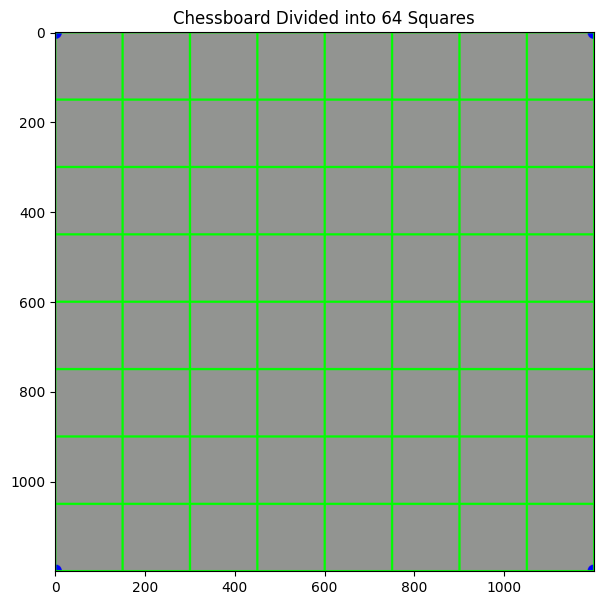

In [166]:
# Assuming area_warped is already defined
# Define number of squares (8x8 for chessboard)
rows, cols = 8, 8

# Calculate the width and height of each square
square_width = width // cols
square_height = height // rows

# Draw the squares on the warped image
for i in range(rows):
    for j in range(cols):
        # Calculate top-left and bottom-right corners of each square
        top_left = (j * square_width, i * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)
        
        # Draw a rectangle for each square
        cv2.rectangle(warped_image, top_left, bottom_right, (0, 255, 0), 4)  # Green color, thickness 2

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Chessboard Divided into 64 Squares")
plt.show()


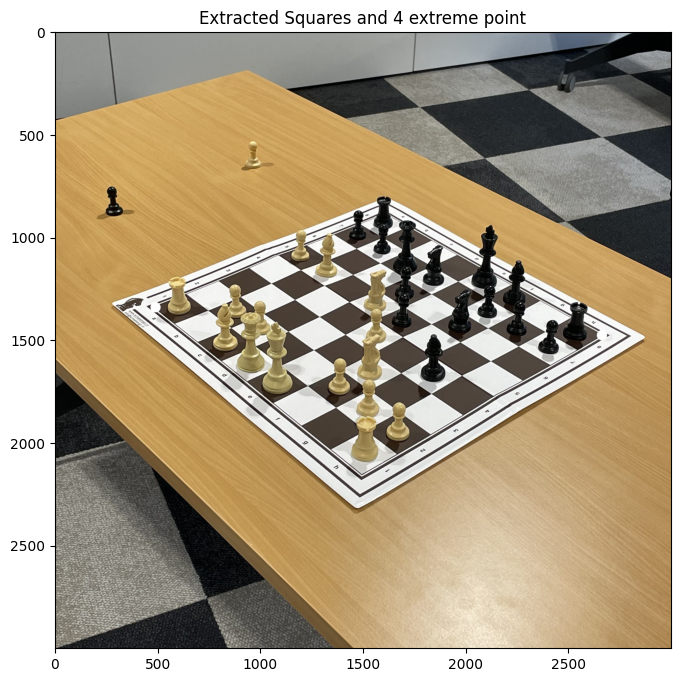

In [167]:
  
# read image and convert it to different color spaces 
#image = cv2.imread(image_path)
#rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


# Compute the inverse perspective transformation matrix
M_inv = cv2.invert(M)[1]  # Get the inverse of the perspective matrix

rows, cols = 8, 8  # 8x8 chessboard

# Calculate the width and height of each square in the warped image
square_width = width // cols
square_height = height // rows

# List to store squares' data in the correct order (bottom-left first)
squares_data_warped = []

for i in range(rows - 1, -1, -1):  # Start from bottom row and move up
    for j in range(cols):  # Left to right order
        # Define the 4 corners of each square
        top_left = (j * square_width, i * square_height)
        top_right = ((j + 1) * square_width, i * square_height)
        bottom_left = (j * square_width, (i + 1) * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)

        # Calculate center of the square
        x_center = (top_left[0] + bottom_right[0]) // 2
        y_center = (top_left[1] + bottom_right[1]) // 2

        # Append to list in the correct order
        squares_data_warped.append([
            (x_center, y_center),
            bottom_right,
            top_right,
            top_left,
            bottom_left
        ])

# Convert to numpy array for transformation
squares_data_warped_np = np.array(squares_data_warped, dtype=np.float32).reshape(-1, 1, 2)

# Transform all points back to the original image
squares_data_original_np = cv2.perspectiveTransform(squares_data_warped_np, M_inv)

# Reshape back to list format
squares_data_original = squares_data_original_np.reshape(-1, 5, 2)  # (num_squares, 5 points, x/y)


for square in squares_data_original:
    x_center, y_center = tuple(map(int, square[0]))  # Convert to int
    bottom_right = tuple(map(int, square[1]))
    top_right = tuple(map(int, square[2]))
    top_left = tuple(map(int, square[3]))
    bottom_left = tuple(map(int, square[4]))

    # Draw necessary lines only (to form grid)
    cv2.line(rgb_image, top_left, top_right, (0, 255, 0), 6)  # Top line
    cv2.line(rgb_image, top_left, bottom_left, (0, 255, 0), 6)  # Left line

    # Draw bottom and right lines only for last row/column
    if j == cols - 1:
        cv2.line(rgb_image, top_right, bottom_right, (0, 255, 0), 8)  # Right line
    if i == 0:
        cv2.line(rgb_image, bottom_left, bottom_right, (0, 255, 0), 8)  # Bottom line

cv2.circle(rgb_image, (int(extreme_points_list[0][0]),int(extreme_points_list[0][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[1][0]),int(extreme_points_list[1][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[2][0]),int(extreme_points_list[2][1])), 25, (255, 255,255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[3][0]),int(extreme_points_list[3][1])), 25, (255, 255, 255), -1)   

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(rgb_image)
plt.title("Extracted Squares and 4 extreme point")
plt.show()